Deep Learning Prototype for Image Super-Resolution Project
==========================================================
Author: Salman Shah

Introduction
------------
In this document, we create a  scalable prototype of a residual neural network that tackles the image super-resolution problem. The purpose of the document is to demonstrate the viability of this model for our given problem.

Summary
-------
### The Problem
Recall that the problem we are trying to solve through this protoptype is a single image super resolution problem. In other words, given an image with resoultion NxM, we would like to recover a higher quality version of that image with resolution 2Nx2M.

### Dataset
The dataset consists of images scraped from google images and processed in a local machine. The final dataset contains a set of 1,087 images of resolution 300x300.

*Disclaimer: The original dataset includes images of resolution 600x600. However, Google Colab's free resources proved to be insufficient to handle images of such size.*

### The Approach
#### Inputs and Outputs
For inputs, the 300x300 images from the dataset are scaled down to 150x150 and fed into the model. The model is then trained against the actual 300x300 images.
#### Loss function
The model uses L<sub>1</sub> loss as opposed to L<sub>2</sub> loss, which, supposedly, is marginally better.

> *We utilize L<sub>1</sub> loss function, which has been demonstrated to be more powerful for performance and convergence* [(source)](https://arxiv.org/pdf/1802.08797.pdf).

During experimentation for this project, however, there didn't appear to be a noticable difference between the two loss functions.

#### Model Architecture
The model is a residual neural network with a series residual blocks followed by a series of convolutional blocks. The model architecture 
- starts with 5 residual blocks
- followed by 1 upsampling block
- followed by 4 3x3 convolutional blocks
- followed by 1 1x1 convolutional block 

A visualization is included in implementation for a clearer picture.

Implementation
--------------

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
DATASET_DIRECTORY = 'FILEPATH_TO_DIRECTORY'  # this is defined locally to preserve the integrity of the contents of my drive

### Example Datapoint
To show what a datapoint from the dataset looks like, below is the first image from the dataset.

Shape of Tensor: (300, 300, 3)


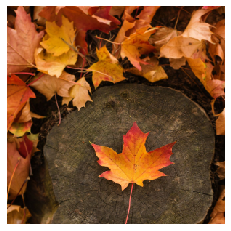

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(DATASET_DIRECTORY + '1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print("Shape of Tensor:", image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

### Building and loading the dataset into memory
For our dataset, 
- We need an array X of inputs consisting of the 1087 images in resolution 150x150
- We need an array Y of expected outputs consisting of the 1087 images in resolution 300x300
- We then need to split X and Y into training and test data

In [0]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Get all filenames from DATASET_DIRECTORY
for _,_,filenames in os.walk(DATASET_DIRECTORY):
  pass

# Store inputs and expected outputs in X and Y
X = []
Y = []
print("Storing images into X and Y...")
for filename in filenames:
  image = Image.open(DATASET_DIRECTORY + filename)
  image_large = np.array(image)
  image_small = np.array(image.resize((150,150)))
  Y.append(image_large)
  X.append(image_small)

# Convert to array and normalize
print("Normalizing...")
X = np.asarray(X)
Y = np.asarray(Y)
X = X.astype('float32')
Y = Y.astype('float32')
X /= 255
Y /= 255

# Split into training and test datasets
print("Splitting into training and test data...")
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Print out the resulting shapes
print("x train:", x_train.shape)
print("y train: ", y_train.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

Storing images into X and Y...
Normalizing...
Splitting into training and test data...
x train: (869, 150, 150, 3)
y train:  (869, 300, 300, 3)
x test: (218, 150, 150, 3)
y test: (218, 300, 300, 3)


### Building and Compiling Model
The prototype coded in Keras using tensorflow backend.

In [0]:
import keras
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, Input, Add
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l1

# Hyperparameters
num_epochs = 50
batch_size = 16
num_filters = 64
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [0]:
# A function for building a residual block
def res_block(input_layer, num_filters=64, activation='relu', kernel_size=(3,3)):
  conv1 = Conv2D(num_filters, kernel_size, padding='same', activation=activation, activity_regularizer=l1(0.01))(input_layer)
  conv2 = Conv2D(num_filters, kernel_size, padding='same', activation=activation, activity_regularizer=l1(0.01))(conv1)
  conv2_1 = Conv2D(3, (1,1), padding='same')(conv2)
  return Add()([conv2_1, input_layer])

In [0]:
# Model architecture
input_layer = Input(shape=(150,150,3))
res_1 = res_block(input_layer)
res_2 = res_block(res_1)
res_3 = res_block(res_2)
res_4 = res_block(res_3)
res_5 = res_block(res_4)
upsampled = UpSampling2D(size=(2,2))(res_5)
conv_1 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(upsampled)
conv_2 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv_2)
conv_4 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv_3)
output_layer = Conv2D(3, (1,1), padding='same')(conv_4)
model = Model(inputs=input_layer, outputs=output_layer)

In [0]:
# Compile model
model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])

#### Visualize Model Architecture
Included below is a graphical representation of the model's architecture.

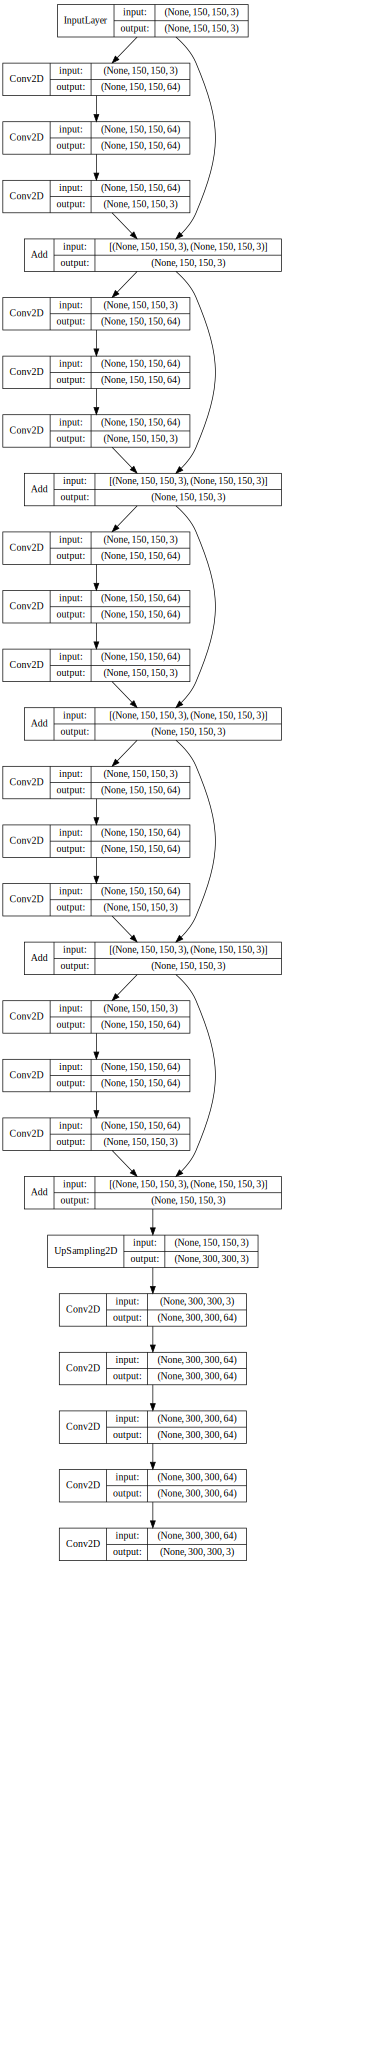

In [0]:
# Visualizing model architecture
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=False, dpi=55).create(prog='dot', format='svg'))

### Training

In [0]:
# Train model and record history
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(x_test, y_test))




Train on 869 samples, validate on 218 samples
Epoch 1/50





869/869 [==============================] - 32s 37ms/step - loss: 46332.9625 - acc: 0.2252 - val_loss: 29057.0064 - val_acc: 0.5722
Epoch 2/50
869/869 [==============================] - 16s 18ms/step - loss: 27123.2295 - acc: 0.7062 - val_loss: 22092.0419 - val_acc: 0.7268
Epoch 3/50
869/869 [==============================] - 16s 18ms/step - loss: 21392.8674 - acc: 0.7985 - val_loss: 17906.0049 - val_acc: 0.8009
Epoch 4/50
869/869 [==============================] - 16s 18ms/step - loss: 17551.6596 - acc: 0.8066 - val_loss: 14763.6468 - val_acc: 0.8058
Epoch 5/50
869/869 [==============================] - 16s 18ms/step - loss: 14514.9824 - acc: 0.8231 - val_loss: 12133.2486 - val_acc: 0.7413
Epoch 6/50
869/869 [==============================] - 16s 18ms/step - loss: 11701.5459 - acc: 0.8185 - val_loss: 9325.2272 - val_acc: 0.7743
Epoch 7/50
869/869 [==============================] - 16s 18ms/step - loss: 7759.4884 - acc: 0.

### Evaluating results
Included below are the accuracy and error plots over epochs. The steadiness of the curves indicates that the model is not overfitting. The model appears to be performing at a 85-90% accuracy.

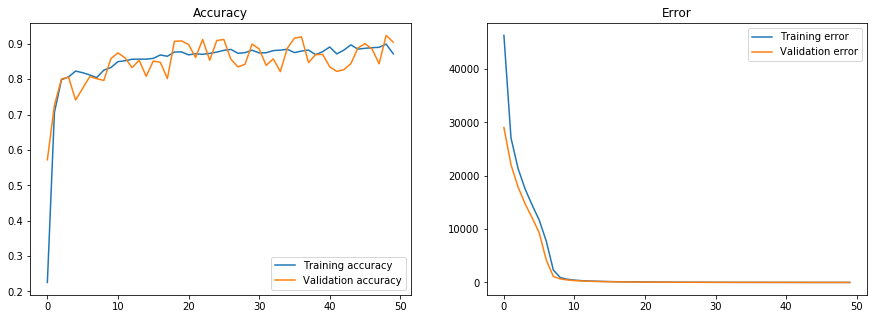

In [0]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Accuracy and error plots
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(acc, label='Training accuracy')
axs[0].plot(val_acc, label='Validation accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title("Accuracy")
axs[1].plot(loss, label='Training error')
axs[1].plot(val_loss, label='Validation error')
axs[1].legend()
axs[1].set_title("Error")
plt.show()

### Visualizing Results
Included below are a few predictions from the test data.

These predictions are far from perfect. However, there is a noticable improvement from the low resolution images. If this model was scaled up and the hyperparamters were tuned, then the model could potentially show production level performance.

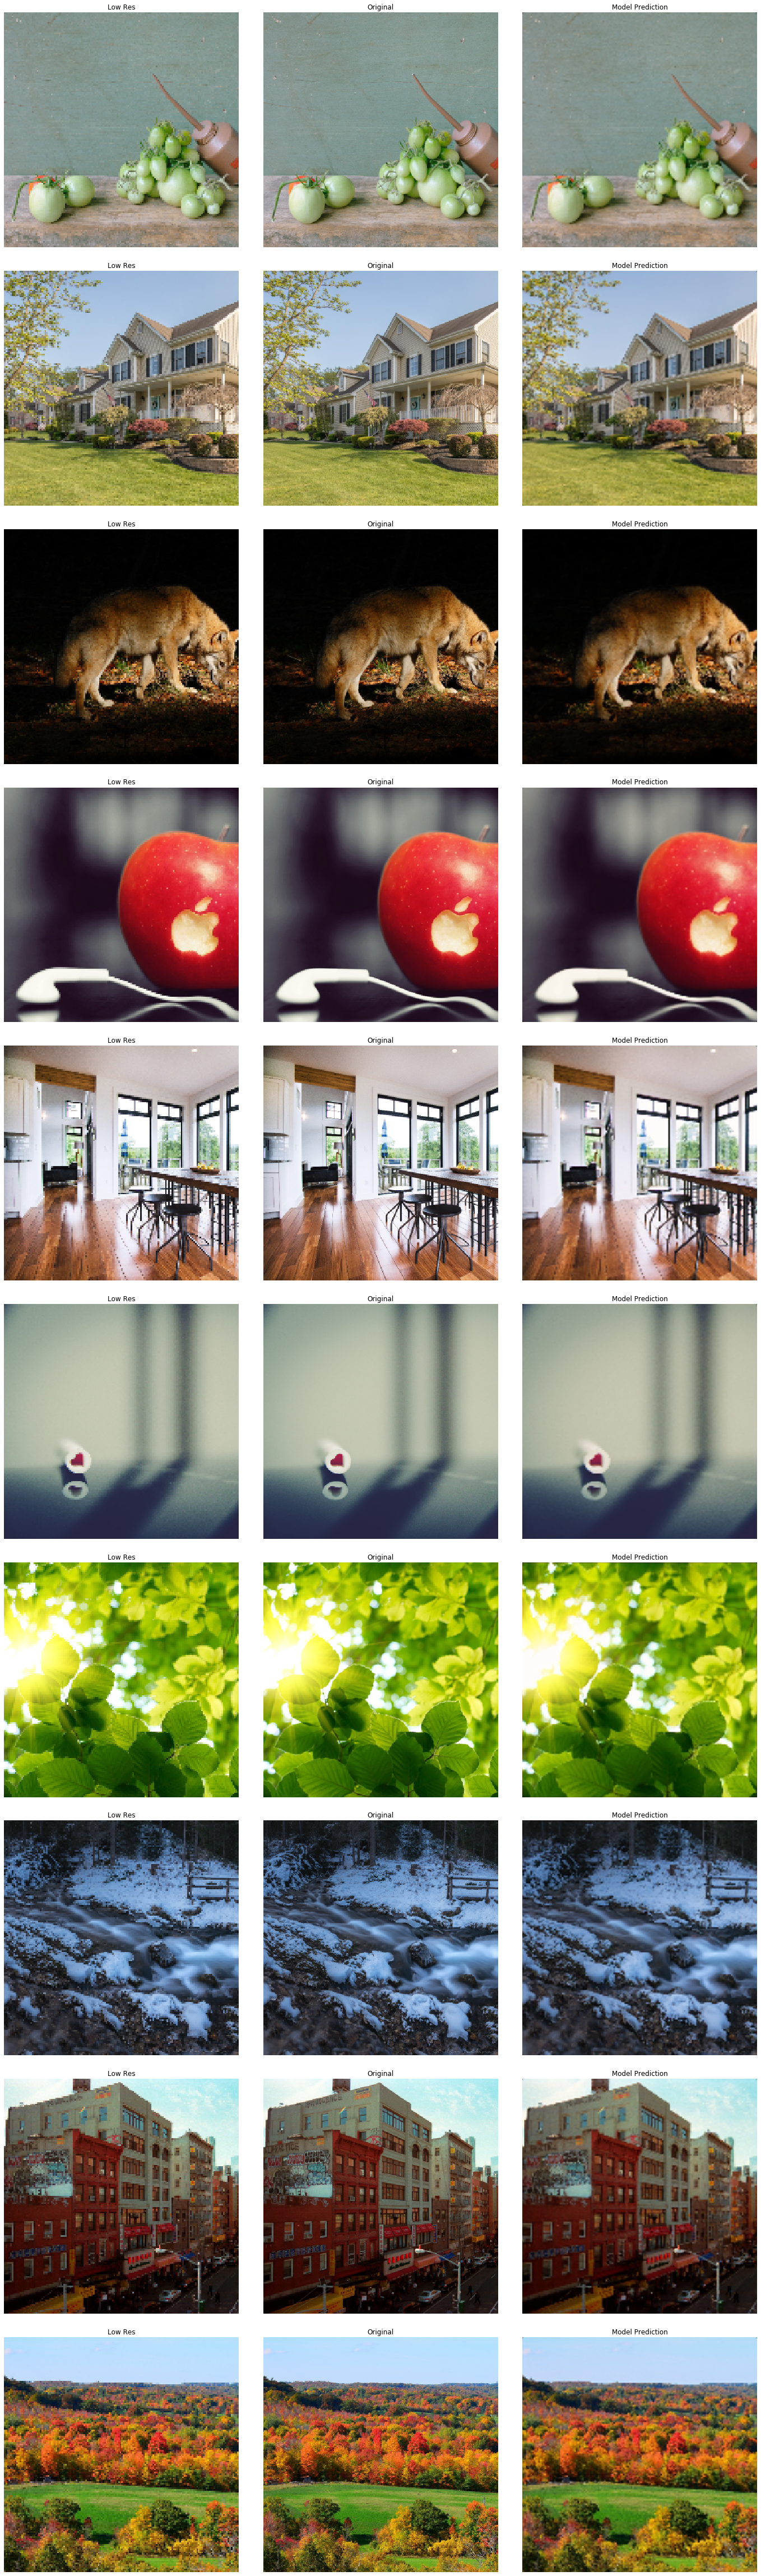

In [0]:
# number of results to display
n = 10

# Display results
fig, axs = plt.subplots(n, 3, figsize=(20,64))
fig.tight_layout()
for index, ax in enumerate(axs):
  ax[0].imshow(x_test[index])
  ax[0].axis('off')
  ax[0].title.set_text('Low Res')
  ax[1].imshow(y_test[index])
  ax[1].axis('off')
  ax[1].title.set_text('Original')
  y_pred = model.predict(x_test[index:index+1])[0] * 255
  y_pred = y_pred.astype('int64')
  y_pred = np.clip(y_pred, 0, 255)
  ax[2].imshow(y_pred)
  ax[2].axis('off')
  ax[2].title.set_text('Model Prediction')
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.show()